# Analysis of Stock Market data

EXECUTE DATA ANALYSIS ON STOCK MARKET USING KAGGLE DATA SET

Dataset Link - https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data

In [ ]:
#Importing All the libraries

import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
#Defining the Hyperparamete

# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

In [ ]:
#Defining the Evaluation Criteria

def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
#Loading Dataset

def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 

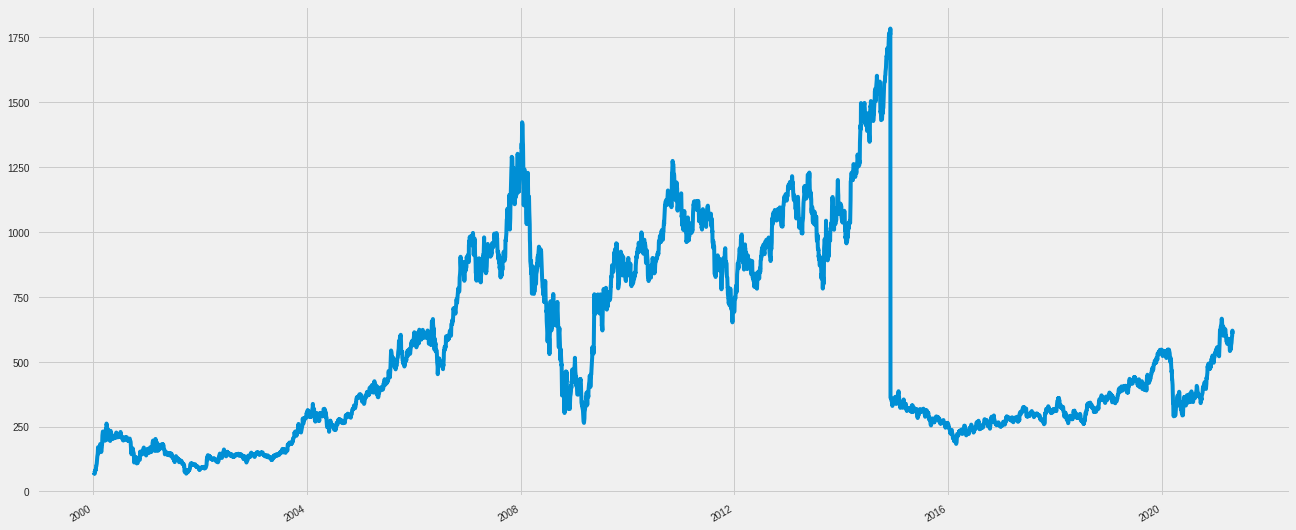

In [ ]:
# load the dataset
stock_name = 'ICICIBANK'

df = pd.read_csv('/content/ICICIBANK.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [ ]:
#Data Preprocessing 

scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)

(5255, 50) (5255, 1)


In [ ]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [ ]:
#Creating the model

def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()

In [ ]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10)                120       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 5s 10ms/step - loss: 0.0068 - val_loss: 6.4042e-04
Epoch 2/6
313/313 [==============================] - 3s 8ms/step - loss: 0.0010 - val_loss: 3.7175e-04
Epoch 3/6
313/313 [==============================] - 3s 8ms/step - loss: 6.9519e-04 - val_loss: 2.6364e-04
Epoch 4/6
313/313 [==============================] - 3s 8ms/step - loss: 5.4121e-04 - val_loss: 1.4723e-04
Epoch 5/6
313/313 [==============================] - 3s 8ms/step - loss: 4.5275e-04 - val_loss: 1.2898e-04
Epoch 6/6
313/313 [==============================] - 3s 8ms/step - loss: 3.9145e-04 - val_loss: 9.6006e-05
Epoch 6: early stopping


In [ ]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)

8/8 [==============================] - 0s 8ms/step


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 43.3993


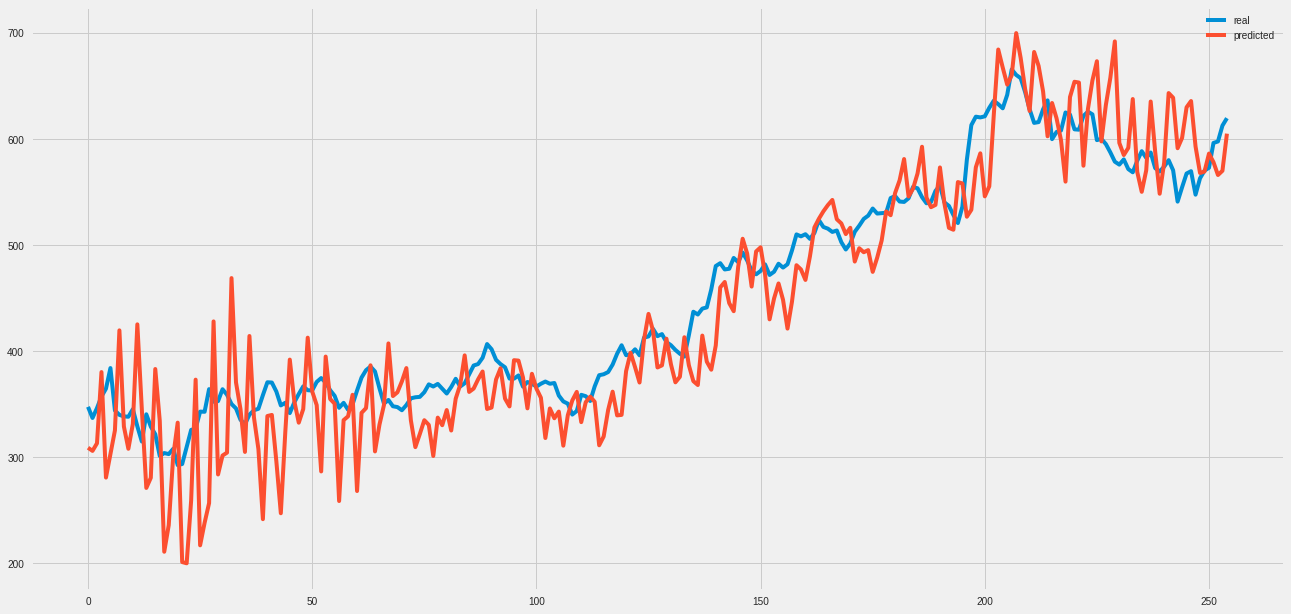

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
#Creating the model 02

def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

Epoch 1/6
313/313 [==============================] - 9s 19ms/step - loss: 0.0033 - val_loss: 4.7343e-04
Epoch 2/6
313/313 [==============================] - 5s 17ms/step - loss: 6.7930e-04 - val_loss: 2.8628e-04
Epoch 3/6
313/313 [==============================] - 5s 17ms/step - loss: 5.2384e-04 - val_loss: 1.4528e-04
Epoch 4/6
313/313 [==============================] - 5s 17ms/step - loss: 4.4155e-04 - val_loss: 1.2917e-04
Epoch 5/6
313/313 [==============================] - 5s 17ms/step - loss: 3.7666e-04 - val_loss: 1.9170e-04
Epoch 6/6
313/313 [==============================] - 5s 16ms/step - loss: 3.6104e-04 - val_loss: 7.9380e-05
Epoch 6: early stopping
8/8 [==============================] - 0s 5ms/step
RMSE: 37.3143


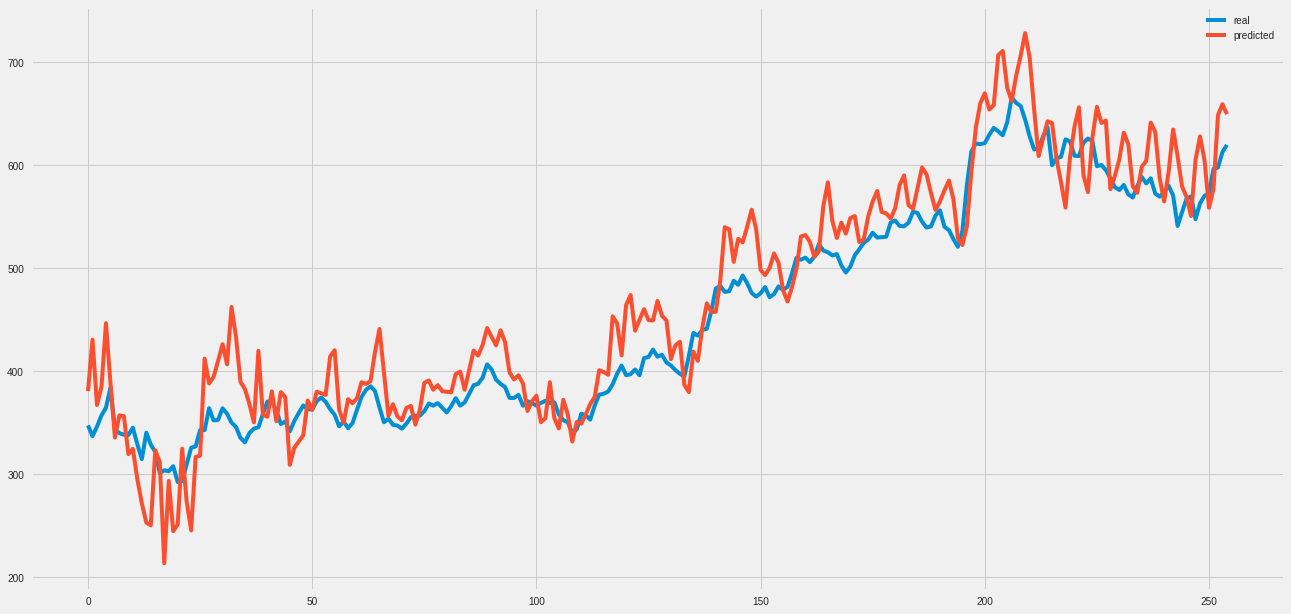

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred2, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
#Creating the model 03

def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          120       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

Epoch 1/6
313/313 [==============================] - 9s 18ms/step - loss: 0.0135 - val_loss: 1.0293e-04
Epoch 2/6
313/313 [==============================] - 6s 20ms/step - loss: 4.4126e-04 - val_loss: 8.0607e-05
Epoch 3/6
313/313 [==============================] - 5s 17ms/step - loss: 3.8539e-04 - val_loss: 1.1417e-04
Epoch 4/6
313/313 [==============================] - 5s 16ms/step - loss: 3.5854e-04 - val_loss: 5.6612e-05
Epoch 5/6
313/313 [==============================] - 5s 17ms/step - loss: 3.3655e-04 - val_loss: 5.1210e-05
Epoch 6/6
313/313 [==============================] - 5s 17ms/step - loss: 3.0262e-04 - val_loss: 1.3157e-04
Epoch 6: early stopping
8/8 [==============================] - 0s 5ms/step


In [ ]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

RMSE: 17.3985


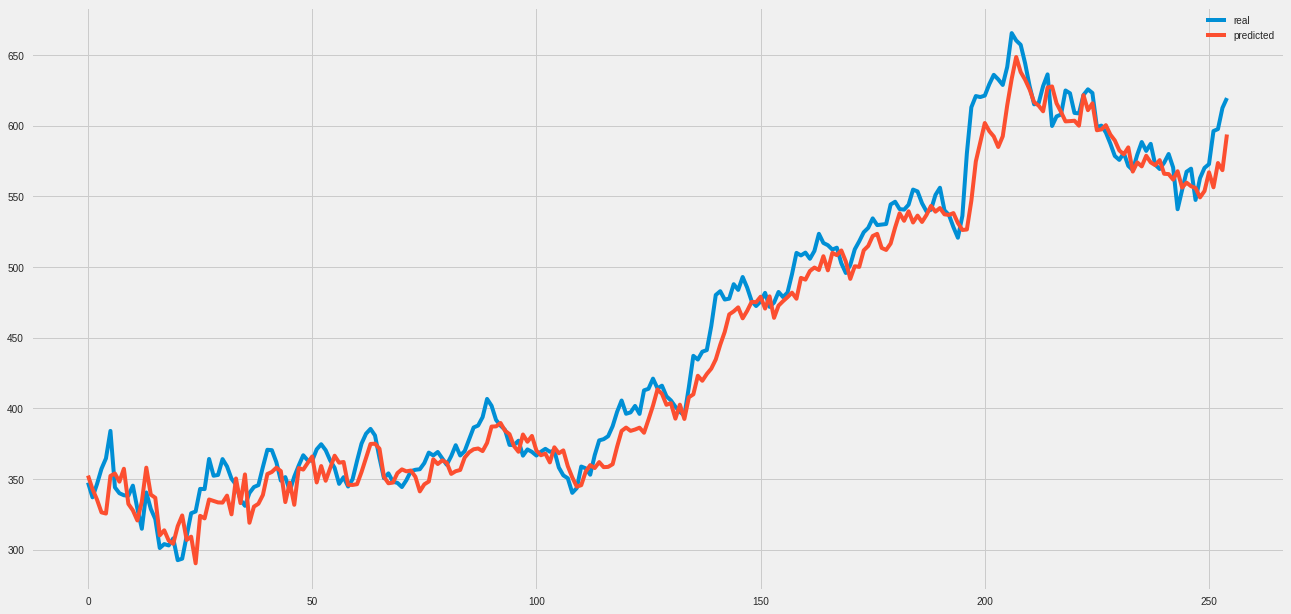

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred3, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

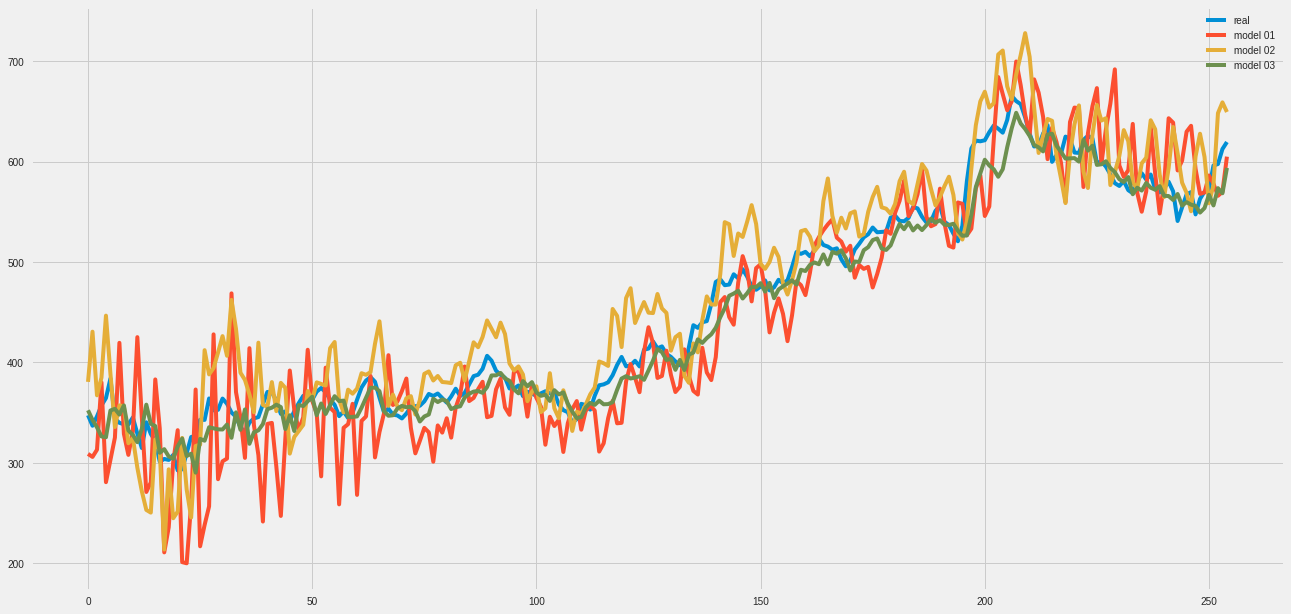

In [ ]:
plt.plot(scaler.inverse_transform(yvalid), label = 'real')
plt.plot(y_pred1, label = 'model 01')
plt.plot(y_pred2, label = 'model 02')
plt.plot(y_pred3, label = 'model 03')
plt.ylabel('')
plt.legend()
plt.show()